In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install tensorflow
!pip install tensorflow==2.9.1

# Necessary for .dcm files
!pip install pydicom

In [1]:
# Import necessary libraries
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import pydicom
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [7]:
#Read Data and Store it in a dataframe
# Generate data paths with labels
data_dir = '/content/drive/MyDrive/Dataset/BrainCT/'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    if os.path.isdir(foldpath):  # Check if it's a directory
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
#Optional
df.to_csv('/content/drive/MyDrive/Dataset/BrainCT/dataframe.csv', index=False)

In [8]:
df.head(5)

,filepaths,labels
0,/content/drive/MyDrive/Dataset/BrainCT/files/c...,files
1,/content/drive/MyDrive/Dataset/BrainCT/files/a...,files
2,/content/drive/MyDrive/Dataset/BrainCT/files/t...,files


In [9]:
df.tail(5)

,filepaths,labels
0,/content/drive/MyDrive/Dataset/BrainCT/files/c...,files
1,/content/drive/MyDrive/Dataset/BrainCT/files/a...,files
2,/content/drive/MyDrive/Dataset/BrainCT/files/t...,files


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  3 non-null      object
 1   labels     3 non-null      object
dtypes: object(2)
memory usage: 176.0+ bytes


In [11]:
# path to a .dcm file
dcm_file_path = '/content/drive/MyDrive/Dataset/BrainCT/files/cancer/1.dcm'

# **Question 1: How can we extract and display metadata (e.g., patient age, gender, date of scan) from a .dcm file?**

In [12]:
dcm_data = pydicom.dcmread(dcm_file_path)

# Define a list of key metadata attributes to check
metadata_attributes = ['PatientID', 'PatientAge', 'PatientSex', 'StudyDate', 'ImagePosition', 'Modality', 'InstanceNumber', 'Manufacturer']

# Initialize a dictionary to store the metadata
metadata_dict = {}

# Extract the metadata attributes
for attr in metadata_attributes:
    value = dcm_data.get(attr, 'Not available')
    metadata_dict[attr] = value

# Display the metadata and check for missing values
for key, value in metadata_dict.items():
    print(f'{key}: {value}')
    if value == 'Not available':
        print(f'Warning: {key} is missing!')

PatientID: 64564456228714525163852073726767
PatientAge: 027Y
PatientSex: F
StudyDate: 20170106
ImagePosition: Not available
Modality: CT
InstanceNumber: 2
Manufacturer: TOSHIBA


# **Question 2: How can we visualize a .dcm file (DICOM image format)?**

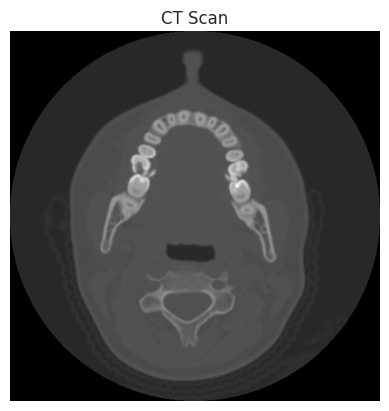

In [13]:
dcm_data = pydicom.dcmread(dcm_file_path)

# Extract the pixel data
pixel_data = dcm_data.pixel_array

# Display the image
plt.imshow(pixel_data, cmap='gray')
plt.title('CT Scan')
plt.axis('off')
plt.show()

# **Question 3: How can we visualize a .dcm file (DICOM image format) with Custom Colormap**

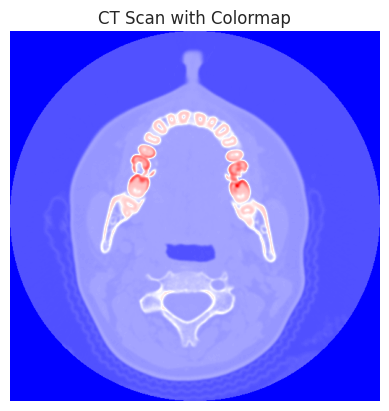

In [14]:
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap
cmap = LinearSegmentedColormap.from_list('mycmap', ['blue', 'white', 'red'])

# Display the image with the colormap
plt.imshow(pixel_data, cmap=cmap)
plt.title('CT Scan with Colormap')
plt.axis('off')
plt.show()

# **Question 4: How can we increase the variety of our medical image dataset using data augmentation?**

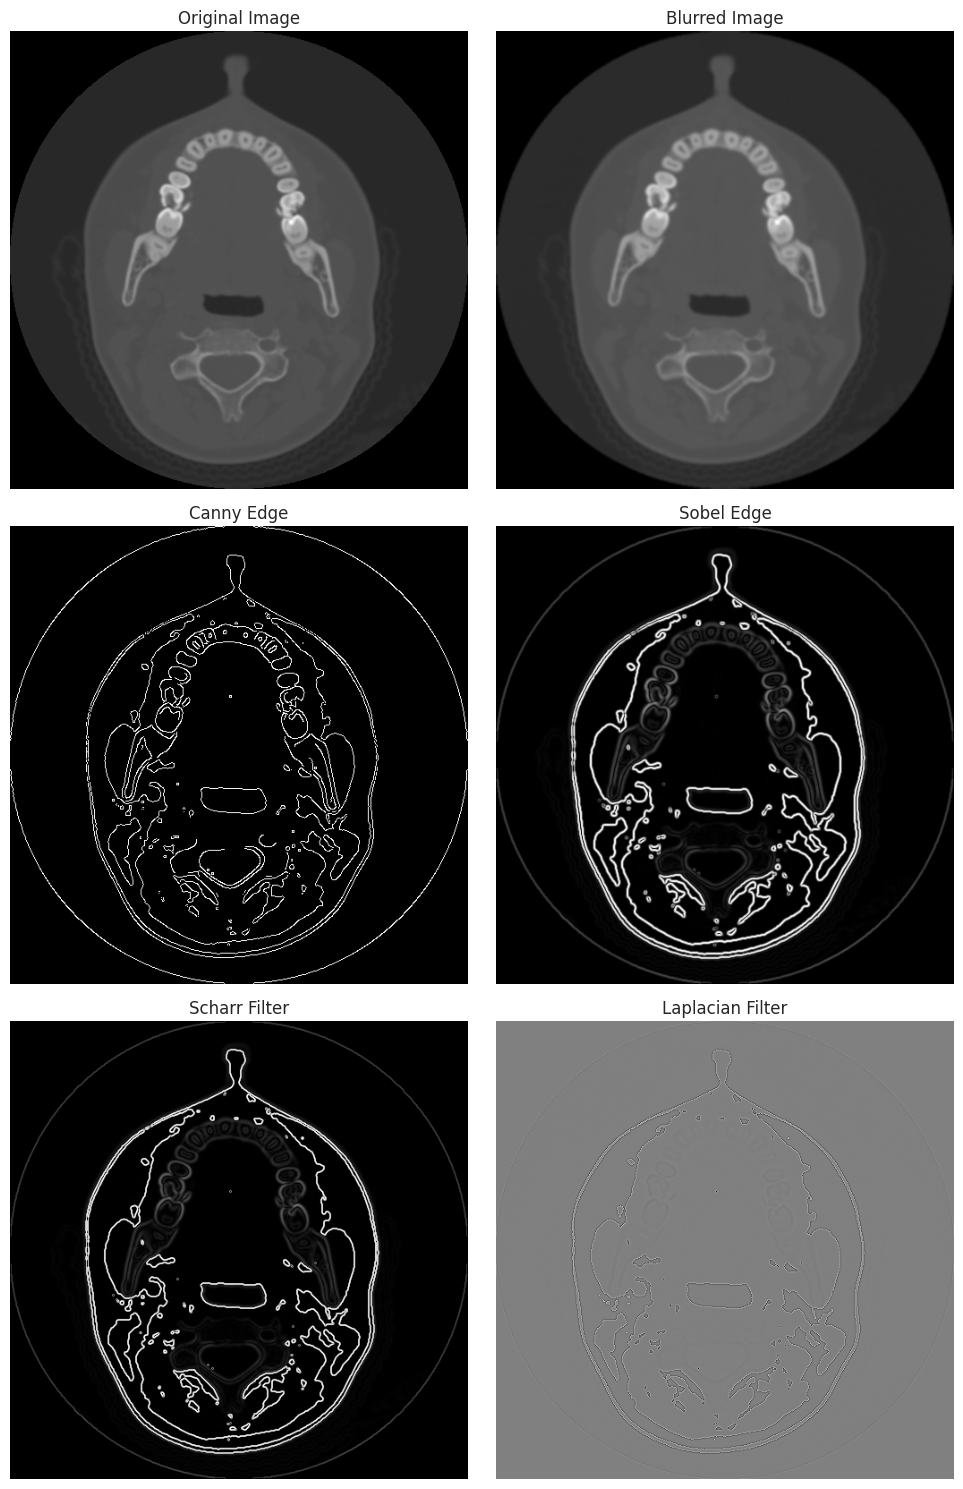

In [20]:
dicom_file = pydicom.dcmread(dcm_file_path)
image = dicom_file.pixel_array
normalized_image = image / image.max()

# Apply Gaussian filter
blurred_image = cv2.GaussianBlur(normalized_image, (5, 5), 0)

# Apply Canny edge detection
edges_cv2 = cv2.Canny((normalized_image * 255).astype(np.uint8), 100, 200)

# Apply Sobel edge detection
sobel_x = cv2.Sobel((normalized_image * 255).astype(np.uint8), cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel((normalized_image * 255).astype(np.uint8), cv2.CV_64F, 0, 1, ksize=5)
edges_sobel = np.hypot(sobel_x, sobel_y)

# Apply Scharr filter
scharr_x = cv2.Scharr((normalized_image * 255).astype(np.uint8), cv2.CV_64F, 1, 0)
scharr_y = cv2.Scharr((normalized_image * 255).astype(np.uint8), cv2.CV_64F, 0, 1)
scharr = np.hypot(scharr_x, scharr_y)

# Apply Laplacian filter
laplacian = cv2.Laplacian((normalized_image * 255).astype(np.uint8), cv2.CV_64F)

# Display
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

axes[0, 0].imshow(normalized_image, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(blurred_image, cmap='gray')
axes[0, 1].set_title('Blurred Image')
axes[0, 1].axis('off')

axes[1, 0].imshow(edges_cv2, cmap='gray')
axes[1, 0].set_title('Canny Edge')
axes[1, 0].axis('off')

axes[1, 1].imshow(edges_sobel, cmap='gray')
axes[1, 1].set_title('Sobel Edge')
axes[1, 1].axis('off')

axes[2, 0].imshow(scharr, cmap='gray')
axes[2, 0].set_title('Scharr Filter')
axes[2, 0].axis('off')

axes[2, 1].imshow(laplacian, cmap='gray')
axes[2, 1].set_title('Laplacian Filter')
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# **Question 5: Are there any differences in the pixel intensity distributions among the CT scan for different types of brain diseases?**

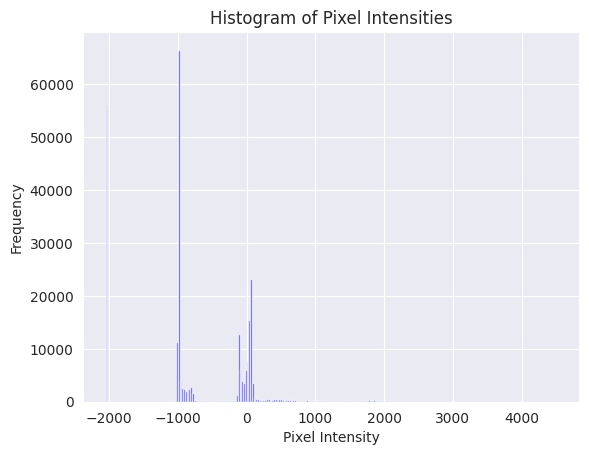

In [16]:
# Read the .dcm file
dcm_data = pydicom.dcmread(dcm_file_path)

# Extract the pixel data
pixel_data = dcm_data.pixel_array

# Plot the histogram of pixel intensities
plt.hist(pixel_data.ravel(), bins=256, color='blue', alpha=0.7)
plt.title('Histogram of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()